<h1>서울특별시 공유 킥보드 현황 관련 데이터 분석</h1>

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests

<h2>서울특별시_전동킥보드_견인 현황</h2>
<h3>서울 시에서 전동킥보드 견인 현황(신고일자, 자치구정보, 주소, 견인유형, 조치일) 제공</h3>

In [2]:
kick_tow = pd.read_excel('Seoul_KickTow.xlsx',header=1,usecols="C:G")
kick_tow.head()

신고일  구정보                      주소                  유형        조치일
0 2023-09-01  도봉구     서울특별시 도봉구 쌍문동 482-1      점자블록, 엘리베이터 입구 2023-09-01
1 2023-09-01  강동구       서울특별시 강동구 성내동 478       버스정류장, 택시 승강장 2023-09-01
2 2023-09-01  성동구  서울특별시 성동구 성수동2가 277-25         횡단보도, 산책로 등 2023-09-01
3 2023-09-01  강동구       서울특별시 강동구 성내동 478       버스정류장, 택시 승강장 2023-09-01
4 2023-09-01  마포구        서울특별시 마포구 도화동 81  보도와 차도가 구분된 도로의 차도 2023-09-01

<h3><strong>주소</strong> 열에 정확한 좌표가 표시 X  -> 지도 시각화를 위해 <strong>그룹화</strong> 진행</h3>
<h3>각 행의 주소를 지도 API를 사용해 <strong>서울 내의 동</strong>으로 변경하고 열 변수로 추가</h3>
<h3>ex. 서울특별시 도봉구 쌍문동 482-1 => 서울특별시 도봉구 쌍문1동</h3> 

In [3]:
def get_kakao_address_combined(address_list):
    # 카카오 API URL
    api_url = "https://dapi.kakao.com/v2/local/search/address.json"
    api_key = "421c5bc48f9d0464b4be853923f5fb09" 
    headers = {
        "Authorization": f"KakaoAK {api_key}"
    }
    combined_addresses = [] 

    for address in address_list:
        params = {
            'query': address  
        }
        try:
            response = requests.get(api_url, headers=headers, params=params, timeout=10)
            if response.status_code != 200:
                print(f"API 요청 실패: {response.status_code}, {response.text}")
                combined_addresses.append(None)
                continue
            
            data = response.json()
            if 'documents' in data and len(data['documents']) > 0:
                document = data['documents'][0]
                jibun_address = document.get('address', None)
                
                if jibun_address:
                    sigungu = jibun_address.get('region_2depth_name', '')
                    bname = jibun_address.get('region_3depth_h_name', '')
                    combined_address = f"서울특별시 {sigungu} {bname}".strip()
                    print(f"주소: {address}, 결합된 주소: {combined_address}")  # 결합된 주소 출력
                else:
                    combined_address = None
                    print(f"주소: {address}, 주소 정보 없음")  # 주소 정보가 없을 때 출력
            else:
                combined_address = None
                print(f"주소: {address}, 검색 결과 없음")  # 검색 결과가 없을 때 출력
        except requests.exceptions.Timeout:
            print(f"Timeout occurred for address: {address}")
            combined_address = None
        except requests.exceptions.RequestException as e:
            print(f"Error occurred for address: {address}: {e}")
            combined_address = None
        combined_addresses.append(combined_address)
    return combined_addresses

In [ ]:
address_list = kick_tow['주소'].tolist()
kick_tow['code'] = get_kakao_address_combined(address_list)
kick_tow.head()

서울 내의 동으로 변경된 데이터를 **code**열로 추가

In [5]:
# 결측치 확인 후
kick_tow['code'].isna().sum()

29

In [6]:
# 결측치 제거
kick_tow.dropna(subset=['code'],inplace=True)

In [7]:
kick_tow.head()

신고일  구정보                      주소                  유형        조치일  \
0 2023-09-01  도봉구     서울특별시 도봉구 쌍문동 482-1      점자블록, 엘리베이터 입구 2023-09-01   
2 2023-09-01  성동구  서울특별시 성동구 성수동2가 277-25         횡단보도, 산책로 등 2023-09-01   
4 2023-09-01  마포구        서울특별시 마포구 도화동 81  보도와 차도가 구분된 도로의 차도 2023-09-01   
5 2023-09-01  성동구  서울특별시 성동구 성수동2가 280-48  보도와 차도가 구분된 도로의 차도 2023-09-01   
6 2023-09-01  중랑구       서울특별시 중랑구 신내동 648               보도 중앙 2023-09-01   

               code  
0    서울특별시 도봉구 쌍문1동  
2  서울특별시 성동구 성수2가3동  
4     서울특별시 마포구 도화동  
5  서울특별시 성동구 성수2가3동  
6    서울특별시 중랑구 신내2동

<h2>서울특별시_전동킥보드_주차구역 현황</h2>

In [8]:
kick_park = pd.read_csv('Seoul_KickPark.csv', encoding='cp949',usecols=[1,2,3,4,5])
kick_park.head()

시군구명          주소            상세위치 거치대 유무  거치대 크기
0  종로구  팔판동 115-63  청와대 춘추문 맞은편 인근      Y     6.0
1  종로구   연건동 218-1    KT광화문 혜화지사 앞      Y     6.0
2  종로구   연건동 178-3   홍익대학교 대학로 맞은편      Y     6.0
3  종로구    동승동 1-24    대학로 마로니에공원 앞      Y     8.0
4  종로구    와룡동 75-4         연악사 맞은편      Y     8.0

**시군구명**의 열과 **주소열**을 합쳐서 **상세주소**열을 새롭게 생성

In [9]:
kick_park['상세주소'] = kick_park['시군구명'] + ' ' + kick_park['주소']
kick_park.head()

시군구명          주소            상세위치 거치대 유무  거치대 크기            상세주소
0  종로구  팔판동 115-63  청와대 춘추문 맞은편 인근      Y     6.0  종로구 팔판동 115-63
1  종로구   연건동 218-1    KT광화문 혜화지사 앞      Y     6.0   종로구 연건동 218-1
2  종로구   연건동 178-3   홍익대학교 대학로 맞은편      Y     6.0   종로구 연건동 178-3
3  종로구    동승동 1-24    대학로 마로니에공원 앞      Y     8.0    종로구 동승동 1-24
4  종로구    와룡동 75-4         연악사 맞은편      Y     8.0    종로구 와룡동 75-4

<h3>위와 동일하게 <strong>그룹화</strong> 진행</h3>
<h3>각 행의 주소를 지도 API를 사용해 <strong>서울 내의 동</strong>으로 변경하고 열 변수로 추가</h3>

In [10]:
address_list = kick_park['상세주소']
kick_park['code'] = get_kakao_address_combined(address_list)

주소: 종로구 팔판동 115-63, 결합된 주소: 서울특별시 종로구 삼청동
주소: 종로구 연건동 218-1, 결합된 주소: 서울특별시 종로구 이화동
주소: 종로구 연건동 178-3, 결합된 주소: 서울특별시 종로구 이화동
주소: 종로구 동승동 1-24, 검색 결과 없음
주소: 종로구 와룡동 75-4, 결합된 주소: 서울특별시 종로구 종로1.2.3.4가동
주소: 종로구 명륜4가 96-4, 결합된 주소: 서울특별시 종로구 혜화동
주소: 종로구 소격동 165-5, 결합된 주소: 서울특별시 종로구 삼청동
주소: 종로구 신문로1가 5-4, 결합된 주소: 서울특별시 종로구 사직동
주소: 종로구 신문로 2가 58, 검색 결과 없음
주소: 종로구 무악동 41-7, 결합된 주소: 서울특별시 종로구 무악동
주소: 종로구 사직동 45-4, 결합된 주소: 서울특별시 종로구 사직동
주소: 종로구 내자동 186-3, 결합된 주소: 서울특별시 종로구 사직동
주소: 종로구 적선동 8-1, 결합된 주소: 서울특별시 종로구 사직동
주소: 종로구 세종로 84-8, 결합된 주소: 서울특별시 종로구 종로1.2.3.4가동
주소: 종로구 공평동 100-19, 결합된 주소: 서울특별시 종로구 종로1.2.3.4가동
주소: 종로구 서린동 26-1, 결합된 주소: 서울특별시 종로구 종로1.2.3.4가동
주소: 종로구 종로2가 84-11, 결합된 주소: 서울특별시 종로구 종로1.2.3.4가동
주소: 중구 중구 을지로 42, 결합된 주소: 서울특별시 중구 명동
주소: 중구 중구 을지로 2가 206, 결합된 주소: 서울특별시 중구 명동
주소: 중구 중구 을지로 178, 결합된 주소: 서울특별시 중구 을지로동
주소: 중구 중구 을지로 50, 결합된 주소: 서울특별시 중구 명동
주소: 용산구 용산구 갈월동 69-29, 결합된 주소: 서울특별시 용산구 남영동
주소: 용산구 용문동 5-157, 결합된 주소: 서울특별시 용산구 용문동
주소: 용산구 한남동 728-1, 결합된 주소: 서울특별시 용산구 한남동
주소: 용산구 

In [11]:
kick_park.head()

시군구명          주소            상세위치 거치대 유무  거치대 크기            상세주소  \
0  종로구  팔판동 115-63  청와대 춘추문 맞은편 인근      Y     6.0  종로구 팔판동 115-63   
1  종로구   연건동 218-1    KT광화문 혜화지사 앞      Y     6.0   종로구 연건동 218-1   
2  종로구   연건동 178-3   홍익대학교 대학로 맞은편      Y     6.0   종로구 연건동 178-3   
3  종로구    동승동 1-24    대학로 마로니에공원 앞      Y     8.0    종로구 동승동 1-24   
4  종로구    와룡동 75-4         연악사 맞은편      Y     8.0    종로구 와룡동 75-4   

                    code  
0          서울특별시 종로구 삼청동  
1          서울특별시 종로구 이화동  
2          서울특별시 종로구 이화동  
3                   None  
4  서울특별시 종로구 종로1.2.3.4가동

In [12]:
# 결측치 확인하고 
kick_park['code'].isna().sum()

5

In [13]:
# 결측치 제거
kick_park.dropna(subset=['code'],inplace=True)

<h3><strong>서울 내의 구</strong>에 해당하는 열 변수도 추가</h3>

In [14]:
kick_tow['district'] = kick_tow['code'].str.extract(r'(서울특별시\s+\w+구)')
kick_park['district'] = kick_park['code'].str.extract(r'(서울특별시\s+\w+구)')
kick_tow.head()

신고일  구정보                      주소                  유형        조치일  \
0 2023-09-01  도봉구     서울특별시 도봉구 쌍문동 482-1      점자블록, 엘리베이터 입구 2023-09-01   
2 2023-09-01  성동구  서울특별시 성동구 성수동2가 277-25         횡단보도, 산책로 등 2023-09-01   
4 2023-09-01  마포구        서울특별시 마포구 도화동 81  보도와 차도가 구분된 도로의 차도 2023-09-01   
5 2023-09-01  성동구  서울특별시 성동구 성수동2가 280-48  보도와 차도가 구분된 도로의 차도 2023-09-01   
6 2023-09-01  중랑구       서울특별시 중랑구 신내동 648               보도 중앙 2023-09-01   

               code   district  
0    서울특별시 도봉구 쌍문1동  서울특별시 도봉구  
2  서울특별시 성동구 성수2가3동  서울특별시 성동구  
4     서울특별시 마포구 도화동  서울특별시 마포구  
5  서울특별시 성동구 성수2가3동  서울특별시 성동구  
6    서울특별시 중랑구 신내2동  서울특별시 중랑구

<h3><strong>그래프 시각화</strong></h3>
<h3>공유킥보드 견인 건수 상위 5개 동/상위 5개 구</h3>

In [62]:
from plotly.subplots import make_subplots

In [64]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 5 견인 대수(동 단위)", "Top 5 견인 대수(구 단위)"))

fig1 = px.bar(top5_dong, x='dong_count', y='code', orientation='h',
              labels={'dong_count': '견인 대수', 'code': '동'}, color='code')
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

fig2 = px.bar(top5_gu, x='gu_count', y='district', orientation='h',
              labels={'gu_count': '견인 대수', 'district': '구'}, color='district')
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(showlegend=False, title_text="Top 5 견인 건수(동 단위, 구 단위)")
fig.show()

In [68]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 5동의 주차 구역 수", "Top 5구의 주차 구역 수"))

fig1 = px.bar(kick_park_dong_count, x='park_count', y='code', orientation='h',
              labels={'park_count': '주차 구역 수', 'code': '동'}, color='code')
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

fig2 = px.bar(kick_park_gu_count, x='park_count', y='district', orientation='h',
              labels={'park_count': '주차 구역 수', 'district': '구'}, color='district')
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(showlegend=False, title_text="Top 5 견인 건수에 따른 주차 구역 수")
fig.show()

In [65]:
kick_tow_grouped = kick_tow.groupby('code').size().reset_index(name='dong_count')
top5_dong = kick_tow_grouped.sort_values(by='dong_count', ascending=False).head(5)
#fig = px.bar(top5_dong, x='dong_count', y='code', orientation='h',
#              labels={'dong_count': '견인 대수', 'code': '동'},color='code')
#fig.update_layout(showlegend=False)
#fig.show()

In [66]:
kick_tow_grouped2 = kick_tow.groupby('district').size().reset_index(name='gu_count')
top5_gu = kick_tow_grouped2.sort_values(by='gu_count', ascending=False).head()
#fig = px.bar(top5_gu, x='gu_count', y='district', orientation='h',
#             labels={'gu_count': '견인 대수', 'district': '구'},color='district')
#fig.update_layout(showlegend=False)
#fig.show()

<h3><strong>그래프 시각화</strong></h3>
<h3>공유킥보드 상위 5개 구 견인 건수 & 가장 많은 견인 건수를 가진 동</h3>

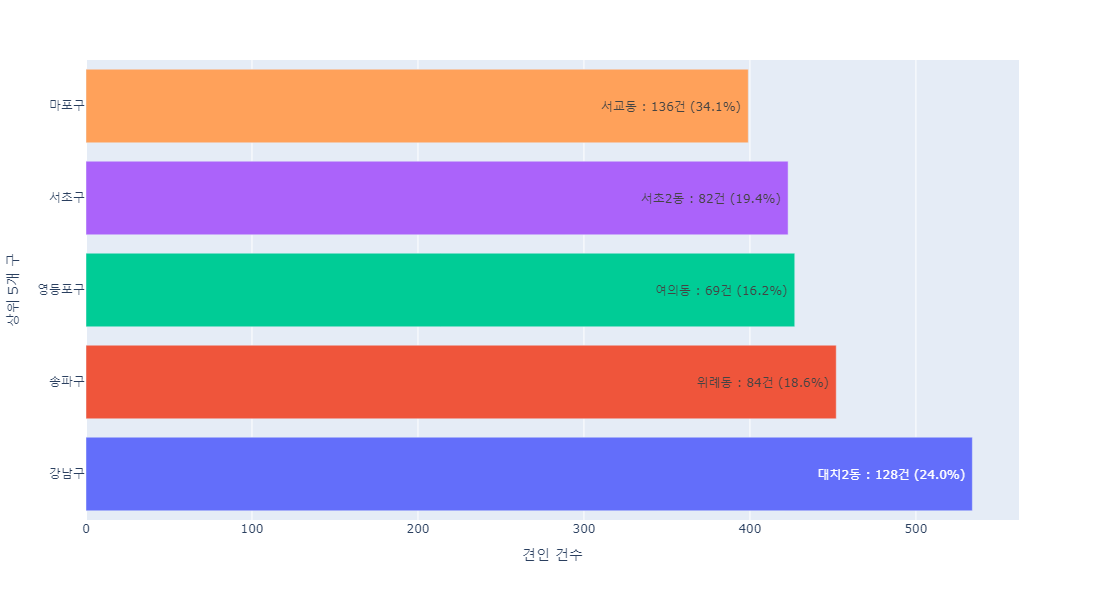

In [18]:
top5_districts = top5_gu['district'].tolist()
filtered_data = kick_tow[kick_tow['district'].isin(top5_districts)]
top_dong_by_district = (
    filtered_data.groupby(['district', 'code'])
    .size()
    .reset_index(name='tow_count')
    .sort_values(['district', 'tow_count'], ascending=[True, False])
)
top_dong_per_district = top_dong_by_district.groupby('district').head(1)
combined_top5 = top5_gu.merge(top_dong_per_district, on='district')

combined_top5['percentage'] = (combined_top5['tow_count'] / combined_top5['gu_count']) * 100
combined_top5['district_without_seoul'] = combined_top5['district'].str.replace('서울특별시 ', '')
combined_top5['code_without_seoul'] = combined_top5['code'].str.replace('서울특별시 ', '')
combined_top5['code_without_seoul'] = combined_top5['code_without_seoul'].str.replace(r'.+구 ', '', regex=True)

combined_top5['text'] = combined_top5.apply(lambda row: f"{row['code_without_seoul']} : {row['tow_count']}건 ({row['percentage']:.1f}%) ", axis=1)

fig = px.bar(combined_top5, x='gu_count', y='district_without_seoul', orientation='h', color='district',
             text='text', labels={'gu_count': '견인 건수', 'district_without_seoul': '상위 5개 구'})
fig.update_traces(textposition='inside')
fig.update_layout(showlegend=False, width=1100, height=600)
fig.show()

<h3>지도 API를 이용해 주소를 검색하고 공유킥보드 주차 구역의 <strong>좌표</strong> 얻어오기</h3>

In [19]:
def get_kakao_address_cordi(address_list):
    api_url = "https://dapi.kakao.com/v2/local/search/address.json"
    api_key = "421c5bc48f9d0464b4be853923f5fb09"  
    headers = {
        "Authorization": f"KakaoAK {api_key}"
    }
    codes = []  # sigungu와 bname을 합친 결과 리스트
    for address in address_list:
        params = {
            'query': address  
        }
        try:
            response = requests.get(api_url, headers=headers, params=params, timeout=10)
            if response.status_code != 200:
                print(f"API 요청 실패: {response.status_code}, {response.text}")
                combined_addresses.append(None)
                continue
            
            data = response.json()
            if 'documents' in data and len(data['documents']) > 0:
                document = data['documents'][0]
                jibun_address = document.get('address', None)
                
                if jibun_address:
                    longitude = jibun_address.get('x', '')
                    latitude = jibun_address.get('y', '')
                    print(f"주소: {address}, x: {longitude}, y: {longitude}")  # 결합된 주소 출력
                else:
                    print(f"주소: {address}, 주소 정보 없음")  # 주소 정보가 없을 때 출력
            else:
                print(f"주소: {address}, 검색 결과 없음")  # 검색 결과가 없을 때 출력
        except requests.exceptions.Timeout:
            print(f"Timeout occurred for address: {address}")
        except requests.exceptions.RequestException as e:
            print(f"Error occurred for address: {address}: {e}")
        codes.append((longitude,latitude))
    return codes

In [28]:
address_list = kick_park['상세주소']
kick_park['cordi_new'] = get_kakao_address_cordi(address_list)
kick_park.head()

주소: 종로구 팔판동 115-63, x: 126.979953523, y: 126.979953523
주소: 종로구 연건동 218-1, x: 127.001901838719, y: 127.001901838719
주소: 종로구 연건동 178-3, x: 127.002411270845, y: 127.002411270845
주소: 종로구 와룡동 75-4, x: 126.990822865672, y: 126.990822865672
주소: 종로구 명륜4가 96-4, x: 127.001767717529, y: 127.001767717529
주소: 종로구 소격동 165-5, x: 126.979780607501, y: 126.979780607501
주소: 종로구 신문로1가 5-4, x: 126.974458087778, y: 126.974458087778
주소: 종로구 무악동 41-7, x: 126.958708064648, y: 126.958708064648
주소: 종로구 사직동 45-4, x: 126.969245145867, y: 126.969245145867
주소: 종로구 내자동 186-3, x: 126.970748481909, y: 126.970748481909
주소: 종로구 적선동 8-1, x: 126.973364046095, y: 126.973364046095
주소: 종로구 세종로 84-8, x: 126.977386807017, y: 126.977386807017
주소: 종로구 공평동 100-19, x: 126.98261272756, y: 126.98261272756
주소: 종로구 서린동 26-1, x: 126.982638354642, y: 126.982638354642
주소: 종로구 종로2가 84-11, x: 126.987728161437, y: 126.987728161437
주소: 중구 중구 을지로 42, x: 126.982372901787, y: 126.982372901787
주소: 중구 중구 을지로 2가 206, x: 126.987104043996, y: 126.987

시군구명          주소            상세위치 거치대 유무  거치대 크기            상세주소  \
0  종로구  팔판동 115-63  청와대 춘추문 맞은편 인근      Y     6.0  종로구 팔판동 115-63   
1  종로구   연건동 218-1    KT광화문 혜화지사 앞      Y     6.0   종로구 연건동 218-1   
2  종로구   연건동 178-3   홍익대학교 대학로 맞은편      Y     6.0   종로구 연건동 178-3   
4  종로구    와룡동 75-4         연악사 맞은편      Y     8.0    종로구 와룡동 75-4   
5  종로구   명륜4가 96-4   흥사단 동숭미술관 맞은편      Y     6.0   종로구 명륜4가 96-4   

                    code   district                             cordi_new  
0          서울특별시 종로구 삼청동  서울특별시 종로구     (126.979953523, 37.5831990172399)  
1          서울특별시 종로구 이화동  서울특별시 종로구  (127.001901838719, 37.5761514176345)  
2          서울특별시 종로구 이화동  서울특별시 종로구  (127.002411270845, 37.5764937862196)  
4  서울특별시 종로구 종로1.2.3.4가동  서울특별시 종로구  (126.990822865672, 37.5749851892766)  
5          서울특별시 종로구 혜화동  서울특별시 종로구  (127.001767717529, 37.5820550929738)

<h3><strong>좌표</strong> 열인 cordi_new를 이용하여 위도와 경도에 해당하는 <strong>longitude, latitude </strong>열을 생성</h3>

In [ ]:
kick_park['cordi_new'].unique()

In [30]:
#str타입으로 전환
kick_park['cordi_new'] = kick_park['cordi_new'].astype(str)

In [31]:
kick_park['cordi_new'] = kick_park['cordi_new'].str.replace("'", "")  
kick_park['cordi_new'] = kick_park['cordi_new'].str.replace("(", "") 
kick_park['cordi_new'] = kick_park['cordi_new'].str.replace(")", "") 

In [33]:
kick_park['cordi_new']

0         126.979953523, 37.5831990172399
1      127.001901838719, 37.5761514176345
2      127.002411270845, 37.5764937862196
4      126.990822865672, 37.5749851892766
5      127.001767717529, 37.5820550929738
                      ...                
185     127.17385058921, 37.5642507572066
186    127.175794086047, 37.5652016727966
187     126.89656648359, 37.4842223847734
188    126.956588222367, 37.4964019323152
189     127.024823216768, 37.603183910563
Name: cordi_new, Length: 185, dtype: object

In [36]:
kick_park[['longitude', 'latitude']] = kick_park['cordi_new'].str.split(',', expand=True)

# 'longitude'와 'latitude'를 실수형으로 변환
kick_park['longitude'] = pd.to_numeric(kick_park['longitude'].str.strip(), errors='coerce')
kick_park['latitude'] = pd.to_numeric(kick_park['latitude'].str.strip(), errors='coerce')
kick_park.head()

시군구명          주소            상세위치 거치대 유무  거치대 크기            상세주소  \
0  종로구  팔판동 115-63  청와대 춘추문 맞은편 인근      Y     6.0  종로구 팔판동 115-63   
1  종로구   연건동 218-1    KT광화문 혜화지사 앞      Y     6.0   종로구 연건동 218-1   
2  종로구   연건동 178-3   홍익대학교 대학로 맞은편      Y     6.0   종로구 연건동 178-3   
4  종로구    와룡동 75-4         연악사 맞은편      Y     8.0    종로구 와룡동 75-4   
5  종로구   명륜4가 96-4   흥사단 동숭미술관 맞은편      Y     6.0   종로구 명륜4가 96-4   

                    code   district                           cordi_new  \
0          서울특별시 종로구 삼청동  서울특별시 종로구     126.979953523, 37.5831990172399   
1          서울특별시 종로구 이화동  서울특별시 종로구  127.001901838719, 37.5761514176345   
2          서울특별시 종로구 이화동  서울특별시 종로구  127.002411270845, 37.5764937862196   
4  서울특별시 종로구 종로1.2.3.4가동  서울특별시 종로구  126.990822865672, 37.5749851892766   
5          서울특별시 종로구 혜화동  서울특별시 종로구  127.001767717529, 37.5820550929738   

    longitude   latitude  
0  126.979954  37.583199  
1  127.001902  37.576151  
2  127.002411  37.576494  
4  126.990823  37.574985  
5  127.001768  37.582055

<h3>행정구역경계를 나타내는 Geojson파일 생성</h3>

In [ ]:
# def get_sgis_boundary_geojson(access_token, adm_cd='11', low_search='1', output_filename='geoSeoul.geojson'):
#     """
#     SGIS API를 통해 행정구역 경계 데이터를 가져와 GeoJSON 파일로 저장하는 함수.

#     Parameters:
#     - access_token (str): SGIS API 액세스 토큰
#     - adm_cd (str): 행정구역 코드 (예: 11은 서울특별시)
#     - low_search (str): 하위 행정구역 포함 여부 (1: 포함, 0: 미포함)
#     - output_filename (str): 저장할 GeoJSON 파일 이름 (기본값: 'boundary.geojson')
#     """
    
#     SGIS_URL = "https://sgisapi.kostat.go.kr/OpenAPI3/boundary/hadmarea.geojson"
    
#     # 파라미터에서 year 제거
#     params = {
#         'accessToken': access_token,
#         'year':2023,
#         'adm_cd': 11,
#         'low_search': 1
#     }
    
#     # SGIS API 요청
#     response = requests.get(SGIS_URL, params=params)

#     # 요청 성공 여부 확인
#     if response.status_code == 200:
#         geojson_data = response.json()
        
#         with open(output_filename, 'w', encoding='utf-8') as f:
#             json.dump(geojson_data, f, ensure_ascii=False, indent=4)
#         print(f"GeoJSON 파일이 성공적으로 저장되었습니다: {output_filename}")
#     else:
#         print(f"API 요청 실패: {response.status_code}, {response.text}")

In [ ]:
# # SGIS API 액세스 토큰 (토큰 발급 과정 생략)
# SGIS_ACCESS_TOKEN = "30a45c82-8db4-480b-b9cc-7a133b59b29a"
# # 함수 호출 예시
# get_sgis_boundary_geojson(SGIS_ACCESS_TOKEN, adm_cd='11', low_search='1', output_filename='geoSeoul.geojson')

In [ ]:
# import time

# # SGIS API를 통해 구별 행정구역 경계를 가져오는 함수
# def get_sgis_boundary_geojson(access_token, adm_cd, low_search='1'):
#     SGIS_URL = "https://sgisapi.kostat.go.kr/OpenAPI3/boundary/hadmarea.geojson"
#     params = {
#         'accessToken': access_token,
#         'year': 2023,
#         'adm_cd': adm_cd,  # 구 코드 사용
#         'low_search': low_search  # 동 단위 포함 여부
#     }
#     response = requests.get(SGIS_URL, params=params)

#     if response.status_code == 200:
#         return response.json()
#     else:
#         print(f"API 요청 실패: {response.status_code}, {response.text}")
#         return None

# # 서울특별시의 각 구별 행정구역 코드
# district_codes = {
#     '종로구': '11010',
#     '중구': '11020',
#     '용산구': '11030',
#     '성동구': '11040',
#     '광진구': '11050',
#     '동대문구': '11060',
#     '중랑구': '11070',
#     '성북구': '11080',
#     '강북구': '11090',
#     '도봉구': '11100',
#     '노원구': '11110',
#     '은평구': '11120',
#     '서대문구': '11130',
#     '마포구': '11140',
#     '양천구': '11150',
#     '강서구': '11160',
#     '구로구': '11170',
#     '금천구': '11185',
#     '영등포구': '11190',
#     '동작구': '11200',
#     '관악구': '11210',
#     '서초구': '11220',
#     '강남구': '11230',
#     '송파구': '11240',
#     '강동구': '11250'
# }

# # 액세스 토큰 (SGIS API에서 발급받은 토큰을 여기에 입력)
# SGIS_ACCESS_TOKEN = "30a45c82-8db4-480b-b9cc-7a133b59b29a"
# district_geojson = {}

# for district_name, adm_cd in district_codes.items():
#     print(f"{district_name} 데이터를 가져오는 중...")  # 각 구 요청 진행 상황 출력
#     geojson_data = get_sgis_boundary_geojson(SGIS_ACCESS_TOKEN, adm_cd, low_search='1')
    
#     if geojson_data:
#         district_geojson[district_name] = geojson_data['features']
#         print(f"{district_name} 데이터가 성공적으로 추가되었습니다.")
#     else:
#         print(f"{district_name} 데이터 요청 실패.")

#     time.sleep(1)  # 각 요청 사이에 1초 딜레이 추가

# all_features = []
# for district_name, features in district_geojson.items():
#     all_features.extend(features)

# combined_geojson = {
#     "type": "FeatureCollection",
#     "features": all_features
# }

# output_filename = 'seoul_all_districts_unique.geojson'
# with open(output_filename, 'w', encoding='utf-8') as f:
#     json.dump(combined_geojson, f, ensure_ascii=False, indent=4)

# print(f"모든 구의 GeoJSON 데이터가 성공적으로 저장되었습니다: {output_filename}")

In [ ]:
# import geopandas as gpd

# # GeoJSON 파일 불러오기
# gdf = gpd.read_file('corrected.geojson')

# # 원래 좌표계를 EPSG:5179 (한국 중부원점 TM 좌표계)로 설정
# gdf = gdf.set_crs(epsg=5179, allow_override=True)

# # WGS84 좌표계 (EPSG:4326)로 변환
# gdf = gdf.to_crs(epsg=4326)

# # 변환된 데이터를 다시 GeoJSON 파일로 저장
# gdf.to_file('seoul_corrected_wgs84.geojson', driver='GeoJSON')

# print("좌표계 변환이 완료되었습니다. 'seoul_corrected_wgs84.geojson' 파일이 생성되었습니다.")

<h3>최종적으로 생성된 <strong>seoul_corrected_wgs84.geojson</strong></h3>

In [37]:
geo_seoul_sig = json.load(open('seoul_corrected_wgs84.geojson',encoding='UTF-8'))
geo_seoul_sig

{'type': 'FeatureCollection',
 'name': 'seoul_corrected_wgs84',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'addr_en': 'Sajik-dong Jongno-gu Seoul',
    'adm_cd': '11010530',
    'adm_nm': '서울특별시 종로구 사직동',
    'y': '1952854',
    'x': '953230'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[126.97398562200746, 37.57823266979035],
      [126.97401404121975, 37.577971246868536],
      [126.97402588957809, 37.57786305805206],
      [126.97404025626552, 37.57773527529902],
      [126.97406834314289, 37.57749109629394],
      [126.97443510165485, 37.57607263259915],
      [126.97444395358238, 37.5760675785073],
      [126.97457716421786, 37.57599654700151],
      [126.97657304645946, 37.57576107703712],
      [126.97707058245952, 37.57576974473209],
      [126.97710569691576, 37.57580041262102],
      [126.97762523696589, 37.56929890747441],
      [126.97644092274696, 37.56932338569587],


<h3><strong>지도 시각화</strong></h3>
<h3>서울특별시 행정구역경계별(동 단위) 공유킥보드 견인 대수</h3>

In [38]:
import folium

In [40]:
map_choropleth = folium.Map(location=[37.5665, 126.9780], zoom_start=11, tiles='cartodbpositron')

# 구별로 견인 건수를 색상으로 시각화
folium.Choropleth(
    geo_data=geo_seoul_sig,
    data=kick_tow_grouped,
    columns=['code', 'dong_count'],  # 구 이름과 견인 건수
    key_on='feature.properties.adm_nm',  # GeoJSON 파일에서 구 이름
    fill_color='Blues',  # 색상 팔레트
    fill_opacity=0.7,
    line_opacity=0.2
).add_to(map_choropleth)

map_choropleth

<h3><strong>지도 시각화(주차 구역 마커 추가)</strong></h3>
<h3>서울특별시 행정구역경계별(동 단위) 공유킥보드 견인 대수와 운영 중인 주차 구역</h3>

In [52]:
map_choropleth2 = folium.Map(location=[37.5665, 126.9780], zoom_start=11, tiles='cartodbpositron')
# 구별로 견인 건수를 색상으로 시각화
folium.Choropleth(
    geo_data=geo_seoul_sig,
    data=kick_tow_grouped,
    columns=['code', 'dong_count'],  # 구 이름과 견인 건수
    key_on='feature.properties.adm_nm',  # GeoJSON 파일에서 구 이름
    fill_color='Blues',  # 색상 팔레트
    fill_opacity=0.7,
    line_opacity=0.2
).add_to(map_choropleth2)
for idx,row in kick_park.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    if pd.notnull(lat) and pd.notnull(lon):  # NaN 값 체크
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,  # 마커의 크기 (값을 작게 설정)
            popup=f"위치 : {row['code']}",
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ).add_to(map_choropleth2)
map_choropleth2

<h3><strong>그래프 시각화</strong></h3>
<h3>견인 건수가 아닌 다른 열 변수에 대한 분석 진행</h3>

<h4>공유 킥보드 견인 기준</h4>
<img src="https://mediahub.seoul.go.kr/uploads/mediahub/2022/03/rySHCzhriItyKHfjTndpbkwWvOGGolOQ.png">

In [77]:
type_counts = kick_tow['유형'].value_counts().reset_index().head(7)
type_counts.columns = ['유형', 'count']  # 열 이름 변경

fig = px.pie(type_counts, 
             values='count', 
             names='유형', 
             title='견인 건수 유형별 빈도',
             labels={'유형': '유형', 'count': '빈도수'},
             color_discrete_sequence=px.colors.qualitative.Pastel)  

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=1000, height=700)
fig.show()

In [78]:
# '신고일'을 datetime으로 변환
kick_tow['신고일'] = pd.to_datetime(kick_tow['신고일'])

# '요일' 열을 추가 (0: 월요일, 6: 일요일)
kick_tow['요일'] = kick_tow['신고일'].dt.day_name()

weekday_counts =  kick_tow['요일'].value_counts().sort_index().reset_index()
weekday_counts.columns = ['요일', 'count']  # 열 이름 변경

fig = px.bar(weekday_counts, 
             x='요일', 
             y='count', 
             labels={'요일': '요일', 'count': '견인 건수'},
             title='요일별 견인 건수')
fig.show()